In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# import datetime
import os
import gc
# from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

import geobleu
from joblib import Parallel, delayed
from tqdm import tqdm

#　擬似スコア
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GroupKFold
from collections import Counter, defaultdict

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src")

import importlib
from util import *
import util

from calc_metrices import *
import calc_metrices

In [2]:
class Config:

  exp = 'ens'
  data = "BA"
  task = 'task1'

  # candidate hypara. group window_size
  window_size = 3
  co_start_day = 0
  co_end_day = 59

  # co-visitation matrix
  n_ago = 3
  
  # train test split. taskごとに要変更
  # start_uid = 60000
  # end_uid = 69999
  train_start_day = 0
  train_end_day = 59
  test_start_day = 60
  test_end_day = 74

  # train, valid split. taskごとに要変更
  model_train_start_day = 0
  model_train_end_day = 40
  model_valid_start_day = 41
  model_valid_end_day = 59

  seed = 123
  debug = False


In [3]:
# INPUT_DIR = f'/root/humob/input/pkl/' #各自データがあるパスに変更の必要あり
# OUTPUT_DIR = f'/root/humob/exp/output/{Config.task}/exp{Config.exp}/'
DATA_DIR = f'/root/humob/pub/data/{Config.task}/{Config.data}'
# if not os.path.exists(OUTPUT_DIR):
#   os.makedirs(OUTPUT_DIR)

In [4]:
all_days = [i for i in range(75)]
weekend_list = [0, 1, 6, 7, 8, 13, 14, 20, 21, 27, 28, 29, 34, 35, 37, 41, 42, 48, 49, 50, 55, 56, 62, 63, 69, 70,]
weekday_list = [day for day in all_days if day not in weekend_list]

In [5]:
## Features to train the model
FEATURES = ['wd', 'over_d', 'log_len_median', 'log_len_mean',
            'log_len_std', 'log_len_skew', 'wd_log_len_median', 'wd_log_len_mean',
            'wd_log_len_std', 'wd_log_len_skew', 'top1_ratio', 'wd_flag',

            "log_len",
            "t0_11_cnt",
            "t12_23_cnt",
            "t24_35_cnt",
            "t36_47_cnt",
            "xy_nunique",

            # ------- suzuki add ------- #

            "xy_var",
            "xy_std",
            "x_var",
            "x_std",
            "y_var",
            "y_std",
            "uid2xy_max",
            "uid2xy_min",
            "uid2x_max",
            "uid2x_min",
            "uid2y_max",
            "uid2y_min",
            "uid2xy_mean",
            "uid2xy_median",
            "uid2x_mean",
            "uid2x_median",
            "uid2y_mean",
            "uid2y_median",
            "uid2xy_wd_var",
            "uid2xy_wd_std",
            "uid2x_wd_var",
            "uid2x_wd_std",
            "uid2y_wd_var",
            "uid2y_wd_std",
            "uid2xy_wd_max",
            "uid2xy_wd_min",
            "uid2x_wd_max",
            "uid2x_wd_min",
            "uid2y_wd_max",
            "uid2y_wd_min",
            "uid2xy_wd_mean",
            "uid2xy_wd_median",
            "uid2x_wd_mean",
            "uid2x_wd_median",
            "uid2y_wd_mean",
            "uid2y_wd_median",
            "uid2xy_diff_max_min",
            "uid2x_diff_max_min",
            "uid2y_diff_max_min",
            "uid2xy_diff_max_mean",
            "uid2x_diff_max_mean",
            "uid2y_diff_max_mean",
            "uid2xy_diff_mean_min",
            "uid2x_diff_mean_min",
            "uid2y_diff_mean_min",
            "uid2xy_diff_max_median",
            "uid2x_diff_max_median",
            "uid2y_diff_max_median",
            "uid2xy_diff_median_min",
            "uid2x_diff_median_min",
            "uid2y_diff_median_min",
            "uid2xy_wd_diff_max_min",
            "uid2x_wd_diff_max_min",
            "uid2y_wd_diff_max_min",
            "uid2xy_wd_diff_max_mean",
            "uid2x_wd_diff_max_mean",
            "uid2y_wd_diff_max_mean",
            "uid2xy_wd_diff_mean_min",
            "uid2x_wd_diff_mean_min",
            "uid2y_wd_diff_mean_min",
            "uid2xy_wd_diff_max_median",
            "uid2x_wd_diff_max_median",
            "uid2y_wd_diff_max_median",
            "uid2xy_wd_diff_median_min",
            "uid2x_wd_diff_median_min",
            "uid2y_wd_diff_median_min",
            'uid_xy_distance',
            'uid_wd_xy_distance',

            # ------------------------------- #

            ]

In [6]:
# lgbm_t_grt_make_data_train.ipynb実行済みであることを前提とする
pqt_list = list_pqt_files(DATA_DIR+"/train/")

In [7]:
train_df = pd.concat([pd.read_parquet(f"{DATA_DIR}/train/{pqt}") for pqt in pqt_list],axis=1)
valid_df = pd.concat([pd.read_parquet(f"{DATA_DIR}/valid/{pqt}") for pqt in pqt_list],axis=1)
test_df = pd.concat([pd.read_parquet(f"{DATA_DIR}/test/{pqt}") for pqt in pqt_list],axis=1)

In [8]:
train_df["target"] = (train_df["pred_t_geobleu"] > train_df["pred_group_t_geobleu"]) # 出し分けのためのtarget設定

In [9]:
# GroupKFold
gkf = GroupKFold(n_splits=4)
for fold,(train_index, test_index) in enumerate(gkf.split(train_df[FEATURES], train_df['target'], train_df["uid"])):
    train_df.loc[test_index, "group"] = fold

## RF

In [10]:
train_df["proba"] = -1
rf_models = []
model_path = f"{DATA_DIR}/{Config.exp}_rfmodels.pkl"
if check_exist_file(model_path):
    print("trained model exists, loading…")
    rf_models = load_file(model_path)
for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]    
    if check_exist_file(model_path):
        rf_models = load_file(model_path)
    else:
        model = RandomForestClassifier(max_depth=6,
                                    max_features=0.50,
                                    n_estimators=500,
                                    random_state=2023
                                    )
        model.fit(X_train, y_train)
        rf_models.append(model)
    y_pred = rf_models[i].predict_proba(X_valid)
    train_df.loc[train_df.group==i,f"rf_proba{i}"] = y_pred[:,1]
    print(f"acc : {accuracy_score((y_pred[:,1]>0.5),y_valid)}")
    print(f"f1 : {f1_score((y_pred[:,1]>0.5),y_valid)}")
train_df["rf_proba"] = train_df[["rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"]].mean(axis=1)
if not check_exist_file(model_path):
    save_file(models, model_path)

trained model exists, loading…
----- fold 0 -------
acc : 0.6361411507959704
f1 : 0.7386202031286743
----- fold 1 -------
acc : 0.6380195241713918
f1 : 0.7410121288163948
----- fold 2 -------
acc : 0.6361319387071129
f1 : 0.7383069127110473
----- fold 3 -------
acc : 0.63696732331794
f1 : 0.7397629942508506


## LGBM

In [11]:
# train_df["lgb_proba"] = -1
lgb_models = []
lgb_model_path = f"{DATA_DIR}/{Config.exp}_lgbmodels.pkl"

if check_exist_file(lgb_model_path):
    models = load_file(lgb_model_path)

for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid)

    if check_exist_file(lgb_model_path):
        models = load_file(lgb_model_path)
    else:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss'
        }

        model = lgb.train(params, lgb_train,
                          valid_sets=[lgb_valid],
                          num_boost_round=10000,
                          callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True)]
                )

        lgb_models.append(model)

    y_pred = lgb_models[i].predict(X_valid)
    train_df.loc[train_df.group==i, f"lgb_proba{i}"] = y_pred

    threshold = 0.5  # This threshold can be tuned based on the requirement
    print(f"acc : {accuracy_score((y_pred > threshold).astype(int), y_valid)}")
    print(f"f1 : {f1_score((y_pred > threshold).astype(int), y_valid)}")

train_df["lgb_proba"] = train_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3"]].mean(axis=1)

----- fold 0 -------
[LightGBM] [Info] Number of positive: 460583, number of negative: 309231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18448
[LightGBM] [Info] Number of data points in the train set: 769814, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598304 -> initscore=0.398405
[LightGBM] [Info] Start training from score 0.398405
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.631107
acc : 0.6408682605561077
f1 : 0.7330627898421637
----- fold 1 -------
[LightGBM] [Info] Number of positive: 459897, number of negative: 309917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18450
[LightG

## XGB

In [12]:
import xgboost as xgb

train_df["xgb_proba"] = -1
xgb_models = []
xgb_model_path = f"{DATA_DIR}/{Config.exp}_xgbmodels.pkl"

if check_exist_file(xgb_model_path):
    xgb_models = load_file(xgb_model_path)
    
for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    if check_exist_file(xgb_model_path):
        xgb_models = load_file(xgb_model_path)
    else:
        param = {'objective': 'binary:logistic'}
        evaluation_results = {}
        model = xgb.train(param,
                        dtrain,
                        num_boost_round=10000,
                        early_stopping_rounds=10,
                        evals=[(dtrain, 'train'), (dvalid, 'eval')],
                        evals_result=evaluation_results,
                        verbose_eval=10
                        )

        xgb_models.append(model)


    y_pred = xgb_models[i].predict(dvalid)
    train_df.loc[train_df.group==i,f"xgb_proba{i}"] = y_pred

    threshold = 0.5  # This threshold can be tuned based on the requirement
    print(f"acc : {accuracy_score((y_pred > threshold).astype(int), y_valid)}")
    print(f"f1 : {f1_score((y_pred > threshold).astype(int), y_valid)}")
train_df["xgb_proba"] = train_df[["xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3"]].mean(axis=1)

----- fold 0 -------
[0]	train-logloss:0.66547	eval-logloss:0.66620
[10]	train-logloss:0.62824	eval-logloss:0.63258
[20]	train-logloss:0.62477	eval-logloss:0.63189
[29]	train-logloss:0.62279	eval-logloss:0.63198
acc : 0.6396290017731533
f1 : 0.7330540889290467
----- fold 1 -------
[0]	train-logloss:0.66577	eval-logloss:0.66573
[10]	train-logloss:0.62889	eval-logloss:0.63096
[20]	train-logloss:0.62535	eval-logloss:0.63020
[30]	train-logloss:0.62326	eval-logloss:0.63015
[34]	train-logloss:0.62246	eval-logloss:0.63024
acc : 0.6417100212388691
f1 : 0.7343087588899453
----- fold 2 -------
[0]	train-logloss:0.66546	eval-logloss:0.66586
[10]	train-logloss:0.62829	eval-logloss:0.63264
[20]	train-logloss:0.62516	eval-logloss:0.63225
[25]	train-logloss:0.62391	eval-logloss:0.63228
acc : 0.6390313479135166
f1 : 0.7318328681775544
----- fold 3 -------
[0]	train-logloss:0.66564	eval-logloss:0.66600
[10]	train-logloss:0.62879	eval-logloss:0.63151
[20]	train-logloss:0.62540	eval-logloss:0.63078
[30]	

In [13]:
import catboost as cb

train_df["cat_proba"] = -1
cat_models = []
cat_model_path = f"{DATA_DIR}/{Config.exp}_catmodels.pkl"

if check_exist_file(cat_model_path):
    cat_models = load_file(cat_model_path)
    
for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]

    train_dataset = cb.Pool(X_train, y_train)
    valid_dataset = cb.Pool(X_valid, y_valid)

    if check_exist_file(cat_model_path):
        cat_models = load_file(cat_model_path)
    else:
        model = cb.CatBoostClassifier(iterations=10000,
                                      eval_metric='Logloss',
                                      early_stopping_rounds=10,
                                      verbose=1000)
        model.fit(train_dataset, eval_set=valid_dataset)

        cat_models.append(model)

    y_pred = cat_models[i].predict_proba(valid_dataset)[:, 1]
    train_df.loc[train_df.group==i, f"cat_proba{i}"] = y_pred

    threshold = 0.5  # This threshold can be tuned based on the requirement
    print(f"acc : {accuracy_score((y_pred > threshold).astype(int), y_valid)}")
    print(f"f1 : {f1_score((y_pred > threshold).astype(int), y_valid)}")

train_df["cat_proba"] = train_df[["cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3"]].mean(axis=1)


----- fold 0 -------
Learning rate set to 0.060096
0:	learn: 0.6869182	test: 0.6870144	best: 0.6870144 (0)	total: 95.2ms	remaining: 15m 51s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6308512554
bestIteration = 426

Shrink model to first 427 iterations.
acc : 0.6407435552697726
f1 : 0.7347815955050361
----- fold 1 -------
Learning rate set to 0.060096
0:	learn: 0.6869855	test: 0.6869393	best: 0.6869393 (0)	total: 49.6ms	remaining: 8m 15s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6294687859
bestIteration = 398

Shrink model to first 399 iterations.
acc : 0.643136337951326
f1 : 0.7371997784480457
----- fold 2 -------
Learning rate set to 0.060096
0:	learn: 0.6869540	test: 0.6869689	best: 0.6869689 (0)	total: 54.2ms	remaining: 9m 2s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6309976445
bestIteration = 346

Shrink model to first 347 iterations.
acc : 0.6402978909136257
f1 : 0.7345742738255111
----- fold 3 -------
Le

In [14]:
train_df["proba"] = train_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3",
                              "cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3",
                              "xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3",
                              "rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"
                              ]].mean(axis=1)

In [15]:
def calc_ml_geobleu(train_df, proba, thr):

    train_df.loc[train_df[proba]>thr,"pred_score"] =  train_df.loc[train_df[proba]>thr, "pred_t_geobleu"]
    train_df.loc[train_df[proba]<=thr,"pred_score"] =  train_df.loc[train_df[proba]<=thr, "pred_group_t_geobleu"]

    print(f"weekday",np.mean(train_df.loc[train_df.d.isin(weekday_list)].groupby("uid")["pred_score"].mean()))
    print(f"weekend",np.mean(train_df.loc[train_df.d.isin(weekend_list)].groupby("uid")["pred_score"].mean()))
    # print(f"weekend : {weekend_t_score*(weekend_t_df.shape[0]/weekend_df.shape[0]) + weekend_grt_score*(weekend_grt_df.shape[0]/weekend_df.shape[0])}")

    geobleu_score = np.mean(train_df.groupby(["uid"])["pred_score"].mean())
    return geobleu_score
    
thr = 0.55 # train_dfでthr調整した.
print("train score")
calc_ml_geobleu(train_df, "proba", thr=thr)

train score
weekday 0.32853793653096325
weekend 0.2514692925442603


0.30867903811721786

weekday 0.32774907980797324
weekend 0.24057337096402476
weekday 0.32775166258082067
weekend 0.24219095135394553
weekday 0.3277402510291603
weekend 0.24373067161997405
weekday 0.3277498148195814
weekend 0.24522428545425795
weekday 0.32777080463454045
weekend 0.24649130762499796
weekday 0.3277898112000975
weekend 0.2476296651179568
weekday 0.3278209952838515
weekend 0.24854246892255807
weekday 0.32788316550111796
weekend 0.2493207880353471
weekday 0.32795972962270137
weekend 0.24994686587050902
weekday 0.3280848550333528
weekend 0.25039971599314376
weekday 0.3282172989973371
weekend 0.25078655970002534
weekday 0.32832861635864646
weekend 0.25104359156378764
weekday 0.3284347304155987
weekend 0.2512216443520627
weekday 0.32849896560838154
weekend 0.25137964165718174
weekday 0.3285543992305155
weekend 0.2514073329075672
weekday 0.32853793653096325
weekend 0.2514692925442603
weekday 0.32845139809964413
weekend 0.25147951883150604
weekday 0.3282894091882542
weekend 0.2514596277040464
weekday

Text(0.5, 1.0, 'ensamble train thr-geobleu curve')

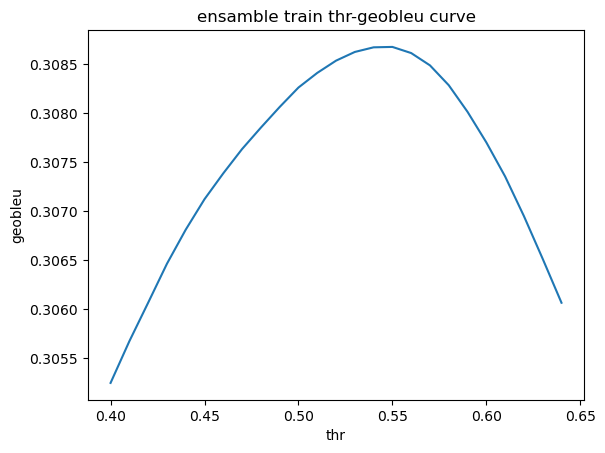

In [16]:
thr_list = [0.40+i*0.01 for i in range(0, 25)]
fig, ax = plt.subplots()
geobleu_list = [calc_ml_geobleu(train_df, "proba", thr=thr) for thr in thr_list]
print(np.max(geobleu_list), thr_list[np.argmax(geobleu_list)])
ax.plot(thr_list, geobleu_list)
ax.set_xlabel("thr")
ax.set_ylabel("geobleu")
ax.set_title("ensamble train thr-geobleu curve")

## Valid

In [17]:
models_list = [lgb_models, cat_models, xgb_models, rf_models]

In [18]:
for name, models in zip(["lgb", "cat", "xgb", "rf"], models_list):
    print(name)
    for i, model in enumerate(models):
        if name == "xgb":
            valid_df[f"{name}_proba{i}"] = model.predict(xgb.DMatrix(valid_df[FEATURES]))
        elif name == "lgb":
            valid_df[f"{name}_proba{i}"] = model.predict(valid_df[FEATURES])
        else:
            valid_df[f"{name}_proba{i}"] = model.predict_proba(valid_df[FEATURES])[:,1]

lgb
cat
xgb
rf


In [19]:
valid_df["proba"] = valid_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3",
                              "cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3",
                              "xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3",
                              "rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"
                              ]].mean(axis=1)

In [20]:
print("valid score")
thr = 0.54
calc_ml_geobleu(valid_df, "proba",thr=thr)

valid score
weekday 0.34346160463662334
weekend 0.275857460634233


0.3263432401577399

In [21]:
valid_df[["uid" ,"d", "wd", "proba"]].to_csv(f"{DATA_DIR}/valid_ensamble_output.csv", index=False)

## Test

In [22]:
for name, models in zip(["lgb", "cat", "xgb", "rf"], models_list):
    print(name)
    for i, model in enumerate(models):
        if name == "xgb":
            test_df[f"{name}_proba{i}"] = model.predict(xgb.DMatrix(test_df[FEATURES]))
        elif name == "lgb":
            test_df[f"{name}_proba{i}"] = model.predict(test_df[FEATURES])
        else:
            test_df[f"{name}_proba{i}"] = model.predict_proba(test_df[FEATURES])[:,1]

lgb
cat
xgb
rf


In [23]:
test_df["proba"] = test_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3",
                              "cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3",
                              "xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3",
                              "rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"
                              ]].mean(axis=1)

In [24]:
test_df[["uid" ,"d", "wd", "proba"]].to_csv(f"{DATA_DIR}/test_ensamble_output.csv", index=False)

EOF